How can this project be improved:
1. Try to set up clusters so there are two of them and they already have 100% purity
2. Figure out how to get more hot-tokens (tokens that appear 4 times more across all users of one subreddit than the other, and there is at least 10 of them for one subreddit)
    - Better attempt of pickinig two distinct and specific subreddits
    - Eliminate overpopulated tokens
    - Try dfferent size of small tokenizer (currently most common 500)
3. Lemmatization process probably has erros in full implementation across the project
4. Play with the simulation itself. Try different hyperparameters, dfferent strategiies for voting, fiix SLACK mechanic. Try odd number of clusters


###### Important set up
- Sets up google drive and a lemmatizer function

In [ ]:
# Mount your drive so you can read/write files permanently
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your folder on drive
%cd /content/drive/MyDrive/Colab Notebooks/p2p tokenizer/

/content/drive/MyDrive/Colab Notebooks/p2p tokenizer


In [ ]:
# Lemmatizing helper funcion
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

wnl = WordNetLemmatizer()
lem = lambda word: wnl.lemmatize(wnl.lemmatize(word, pos="n"), pos="v")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#### Token preparation
- you do not need to run this every time. Run it once to store all tokens in a file and then you have a checkpoint to work with
- Stores 8502 unk tokens in unk_tokens.txt from the two datasets (NBA and Politics


##### General tokenizer (with full vocab)

In [ ]:
import json
from tokenization import FullTokenizer
from collections import Counter

In [ ]:
# Tokenizer with full vocab
tokenizer = FullTokenizer("vocab.txt", True)

In [ ]:
with open("nba.txt") as n, open("politics.txt") as p:
  nba_comments = " ".join(json.loads(row)["comment"] for row in n)
  politics_comments = " ".join(json.loads(row)["comment"] for row in p)

all_comments = nba_comments + ' ' + politics_comments

##### Small tokenizer (with 500 most common tokens in vocab)

###### Small Tokenizer

In [ ]:
# et most common 500 tokens and save them to a file
tokenized = tokenizer.tokenize(all_comments)
tokenized_counter = Counter(tokenized).most_common(500)
small_vocab = "\n".join(key for key, value in tokenized_counter)

with open('small_vocab.txt', 'w') as f:
  f.write(small_vocab)

###### Get UNK tokens from the dataset

In [ ]:
small_tokenizer = FullTokenizer("small_vocab.txt", True)

In [ ]:
all_tokens = list(lem(token) for token in Counter(tokenized).keys())
small_vocab_lemmmed = list(lem(key) for key, value in Counter(tokenized).most_common(500))

# Get all tokens not in most common 500
set_diff = set(all_tokens) - set(small_vocab_lemmmed)

clean_token_diff = [i for i in set_diff if "#" not in i]
unclean_small_vocab_lemmmed = [token for token in list(small_vocab_lemmmed) if "#" in token]

small_vocab_lemmmed_list = list(small_vocab_lemmmed) # 500 most common tokens
clean_token_diff_list = list(clean_token_diff) # Not first 500 tokens without wildcard (all other tokens without wildcards)
unclean_small_vocab_lemmmed_list = list(unclean_small_vocab_lemmmed) # 500 most common tokens with wildcard

In [ ]:
# From all tokens that are classified as unique tokens (dont have a wildcard after tokenization),
# find those that do not get matched with wildcard tokens if we choose to use tokenizer with only 500 most common tokens.
# Those are UNK tokens since the wildcard tokens (500 most common) cannot catch them

import re

to_rmv = [".", "^", "|"]

for i in to_rmv:
  try:
    unclean_small_vocab_lemmmed_list.remove(i)
  except:
    pass

i = 0
not_found_tokens = []
count = 0
for clean in clean_token_diff_list: # clean uncommon
    for reg_token in unclean_small_vocab_lemmmed_list: # wildcard common
        i += 1

        try:
            # Match with regex
            if re.match(reg_token.replace("#", ".") + r"\b", clean) is not None:
                break
        except:
            pass

    else:
        count += 1
        not_found_tokens.append(clean)

In [ ]:
# Check which of the potential UNK token is an actual UNK token
actual_unks = []
for i in not_found_tokens:
  if "[UNK]" in small_tokenizer.tokenize(i):
    actual_unks.append([i, small_tokenizer.tokenize(i)])

In [ ]:
_unks = list([i[0] for i in sorted(actual_unks) if i[0].isalnum()])
_word_tokens = [token for token in _unks if not any(char.isdigit() for char in token)]

In [ ]:
# Store unk tokens in a file
with open('unk_tokens.txt', 'w') as f:
  f.write("\n".join(_word_tokens))

#### Simulation preparation
- uses binary representation of integer to represent user tokens for faster simulation

In [ ]:
import json
import numpy as np
from tokenization import FullTokenizer

##### Get all comments

In [ ]:
from collections import defaultdict

In [ ]:
with open("nba.txt") as n, open("politics.txt") as p:
    nba_comments = defaultdict(list)
    politics_comments = defaultdict(list)

    for row in n:
        nba_comments[json.loads(row)['author']].append(json.loads(row)['comment'])

    for row in p:
        politics_comments[json.loads(row)['author']].append(json.loads(row)['comment'])

In [ ]:
with open('unk_tokens.txt', 'r') as n:
  unk_tokens = n.read().split()

In [ ]:
all_comments = nba_comments.copy()
all_comments.update(politics_comments)

##### Get all users' UNK tokens

In [ ]:
from collections import Counter


all_unk_tokens = unk_tokens


all_tokens_count = len(all_unk_tokens)
all_tokens_user_count = [0] * all_tokens_count

# Uncomment this to remove tokens that have more then 50 occurences

"""
for user in _users:
    user_bin = "0" * (all_tokens_count - len(bin(user)[2:])) + bin(user)[2:]
    for i in range(len(user_bin)):
        all_tokens_user_count[i] += int(user_bin[i])
all_unk_tokens = list(map(lambda x: x[1], filter(lambda token_key_value: all_tokens_user_count[token_key_value[0]] <= 50, enumerate(all_unk_tokens))))
"""

def get_user_unk_tokens(user):
    """
    Get a user's UNK tokens
    :param user: user index.
    :return: A list of integers representing a count for each token (array of 8502 integers).
    """
    joined_comments = " ".join(all_comments[user]).lower()
    return [joined_comments.count(n) for n in all_unk_tokens]

def get_user_unk_tokens_optimized(user):
    """
    Get a user's UNK tokens using Counter
    :param user: user index.
    :return: A list of integers representing a count for each token (array of 8502 integers).
    """
    joined_comments = " ".join(all_comments[user]).lower()

    word_counts = Counter(joined_comments.lower().split())
    return [word_counts[unk] for unk in all_unk_tokens]

In [ ]:
""" Get all users and their tokens
{
    user1: [3, 0, 0, 1, 4...],
    user2: [0, 4, 2, 1, 1...],
    user3: [7, 0, 1, 8, 2...],
}
"""

rels = { user: get_user_unk_tokens_optimized(user) for user in [i for i in all_comments] }

In [ ]:
# Converts array of booleans to an integer that has a binaru representation of that array
# [1, 0, 0] => bin 100 => int 4
bool_arr_to_int = lambda arr: int("".join(map(lambda x: str(int(x)), arr)), 2)

# All 200 users represented as array of 8502 bit integer representing existance of tokens
# User with binary representation of 101100... has first token, third token, fourth...
_users = list(bool_arr_to_int(list(map(bool, i))) for i in rels.values())

##### Optimized token search with binary digits

In [ ]:
def matching(source_user: int, target_user: int):
    """
    Get a matching score for two users. Matching score is calculated by seeing how many
    tokens both users have in common divided by the amount of tokens a source_user has
    This method uses bitwise and to quickly determine the amount of same tokens
    :param source_user: 8502 bit integer representing first user.
    :param target_user: 8502 bit integer representing secoond user.
    :return: Matching score between two users (float)
    """

    if source_user == target_user: return 0 # This case would return too high value for the matching matrix
    source_user_shift = 2 ** (len(bin(source_user)) - 2) + source_user
    return bin(source_user_shift & target_user).count("1") / bin(source_user).count("1")

In [ ]:
# focus = _users[80:120]
focus = _users
matrix = list(list(matching(user_j, user_i) for user_i in focus) for user_j in focus)
"""
_user1 = {token1, token2, token3, token4}
_user2 = {token4, token5, token6, token7, token12}
...
_usern = {token3, token6, token7}

_users = [user1, user2, ..., usern]

matrix = [
    [matching(user1, user1), matching(user1, user2), ..., matching(user1, usern)],
    [matching(user2, user1), matching(user2, user2), ..., matching(user2, usern)],
    ...
    [matching(usern, user1), matching(usern, user2), ..., matching(usern, usern)],
]
"""

# User x with all others

# User x with user y

# Should look like this
"""
     u1, u2, u3, ..., un
u1    1 0.2 xxx
u2  0.2   1 yyy      ...
u3  xxx yyy   1
...
un      ...            1

"""


'\n     u1, u2, u3, ..., un\nu1    1 0.2 xxx\nu2  0.2   1 yyy      ...\nu3  xxx yyy   1\n...\nun      ...            1\n\n'

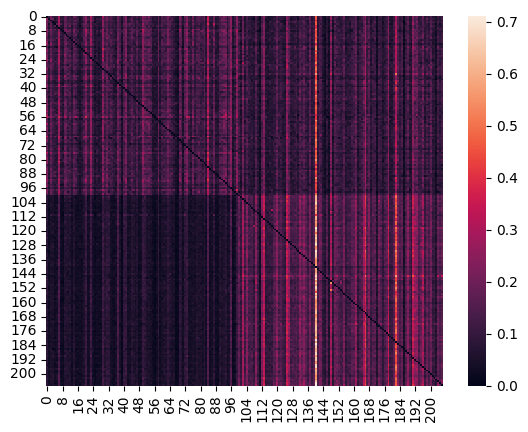

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ax = sns.heatmap(matrix)

# Plot the matching matrix (matrix of matching scores for all users)
plt.show()

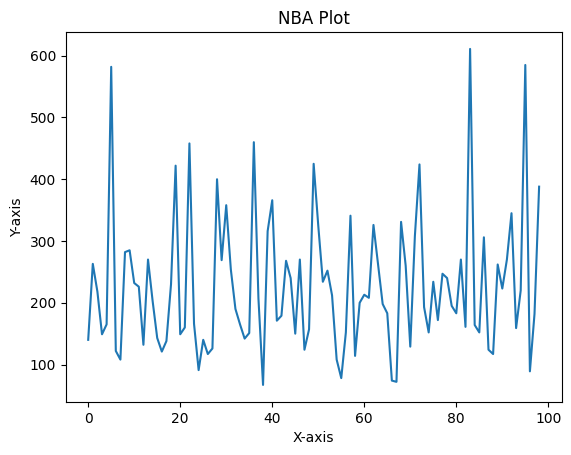

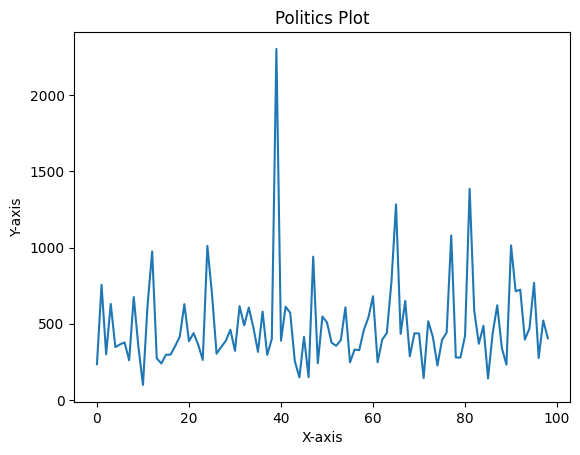

224.15
480.61
203
413


In [ ]:
# Get number of tokens for each user in both subreddits
# Also get meian and mean for each subreddit

import matplotlib.pyplot as plt
import statistics

nba_users_unk_counts = [bin(user).count("1") for user in _users[1:100]]
politics_users_unk_counts = [bin(user).count("1") for user in _users[101:200]]

indices = range(len(nba_users_unk_counts))
fig, ax = plt.subplots()
ax.plot(indices, nba_users_unk_counts)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('NBA Plot')

plt.show()

indices = range(len(politics_users_unk_counts))
fig, ax = plt.subplots()
ax.plot(indices, politics_users_unk_counts)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Politics Plot')

plt.show()

print(sum(nba_users_unk_counts) / 100)
print(sum(politics_users_unk_counts) / 100)

# Calculate middle values
print(statistics.median(nba_users_unk_counts))
print(statistics.median(politics_users_unk_counts))

##### Simulation setup

In [ ]:
from numpy.random import randint

def get_random_cluster():
    """
    Get 10 random clusters using randint to
    :param source_user: 8502 bit integer representing first user.
    :param target_user: 8502 bit integer representing secoond user.
    :return: Matching score between two users (float)
    """

    token_cluster_indices = [randint(0, 10) for unk_token in all_unk_tokens]

    clusters_count = 10
    cluster_str_len = len(all_unk_tokens)
    clusters_arr = [list('0' * cluster_str_len) for i in range(clusters_count)]

    for index, token_cluster_index in enumerate(token_cluster_indices):
        clusters_arr[token_cluster_index][index] = "1"

    return list(map(lambda cluster_arr: int(''.join(cluster_arr), 2), clusters_arr))

clusters = get_random_cluster()

In [ ]:
import numpy as np

# Matching score of user x in regards to a cluster
def get_cluster_index_with_max_matching_score(_user):
    """
    Get index of cluster for which a user has most tokens in
    :param _user: 8502 bit integer representing user.
    :return: index of cluster with max score
    """

  matching_scores = [matching(_user, cluser) for cluser in clusters]
  return np.argmax(matching_scores)

# Matching score of user x in regards to a cluster
def get_max_matching_score(_user, _clusters):
    """
    Get max matching score for a user and all clusters
    :param _user: 8502 bit integer representing user.
    :param _clusters: array of 10 elements
    :return: index of cluster with max score
    """

  matching_scores = [matching(_user, cluser) for cluser in _clusters]
  return max(matching_scores)

7

In [ ]:
def get_better_distributed_clusters(min_count=0, max_count=9999):
    """
    Attempts to find clusters which will contain at least min_count users for each cluster
    and at most max_count users in all clusters. It attempts with "while True: find()"
    :param min_count: min number of users in final clusters.
    :param max_count: max number of users in final clusters.
    :return: Array of 10 clusters represented as 8502 bit integer.
    Adding up all tokens should result in 2**2503 - 1 (all ones in binary representation)
    """

    global clusters
    while True:
        cluster_user = [list() for i in range(10)]
        clusters = get_random_cluster()

        for index, user in enumerate(_users):
            cluster = get_cluster_index_with_max_matching_score(user)
            cluster_user[cluster].append(index)

        if min(list(map(len, cluster_user))) >= min_count and max(list(map(len, cluster_user))) <= max_count:
            return clusters, cluster_user

clusters, cluster_user = get_better_distributed_clusters(5, 50)

[18, 21, 19, 18, 33, 18, 11, 8, 43, 18]

In [ ]:
import random

all_tokens_count = len(all_unk_tokens)

# Get an array of all tokens with user count
all_tokens_user_count = [0] * all_tokens_count
for user in _users:
    user_bin = "0" * (all_tokens_count - len(bin(user)[2:])) + bin(user)[2:]
    for i in range(len(user_bin)):
        all_tokens_user_count[i] += int(user_bin[i])

def get_x_tokens_not_in_cluster(_user, _cluster, x=100):
    """
    Get x (count) amount of user tokens that are not already in cluster
    :param _user: 8502 bit integer representation of user.
    :param _cluster: 8502 bit integer representation of user.
    :padam x: number of tokens
    :return: Array of x indices of tokens that are not in cluster.
    """

    tokens_int = _user & ~_cluster # Exists on user and not in cluster
    tokens_cut = bin(tokens_int)[2:]
    missing_leading_zeroes = all_tokens_count - len(tokens_cut)
    tokens = "0" * missing_leading_zeroes + tokens_cut

    one_indices = [i for i, val in enumerate(tokens) if val == "1" and all_tokens_user_count[i] <= 10]

    return random.sample(one_indices, min(x, len(one_indices)))

In [ ]:
import bisect

def binary_search(arr, target):
    index = bisect.bisect_left(arr, target)
    if index < len(arr) and arr[index] == target:
        return index
    else:
        return -1  # Target not found

In [ ]:
import math

# Map to fetch cluster by token
def get_unk_tokens_cluster_map():
    """
    returns a dictionary of key = token index; value = cluster index where token is present
    Used for fast accessing cluster based on token
    :return: A dictionary of key = token index; value = cluster index where token is present.
    """
    all_tokens_count = len(all_unk_tokens)
    unk_tokens_cluster_map = [-1] * len(all_unk_tokens)
    for i, c in enumerate(clusters):
        one_indices = [j + all_tokens_count - len(bin(c)[2:]) for j, val in enumerate(bin(c)[2:]) if val == "1"]
        for index in one_indices:
            unk_tokens_cluster_map[index] = i

    return unk_tokens_cluster_map

def get_new_clusters_after_transfering_token(cluster_from_index, cluster_to_index, token_to_transfer):
    """
    Transfer token from cluster to cluster and return new clusters
    :param _cluster_from_index: 8502 bit integer representation of cluster where token exists.
    :param _cluster_to_index: 8502 bit integer representation of cluster where the token will go.
    :param token_to_transfer: token index to transfer
    :return: Array of 10 clusters represented as 8502 bit integer
    """

    # token transition from cluster to cluster
    temp_clusters = [i for i in clusters]
    temp_clusters[cluster_from_index] = temp_clusters[cluster_from_index] - (2 ** (all_tokens_count - token_to_transfer - 1))
    temp_clusters[cluster_to_index] = temp_clusters[cluster_to_index] + (2 ** (all_tokens_count - token_to_transfer - 1))
    return temp_clusters


def get_new_clusters_after_transfering_token_multiple(clusters_from_indices, cluster_to_index, tokens_to_transfer):
    """
    Transfer tokens from cluster to cluster and return new clusters
    :param _cluster_from_index: 8502 bit integer representation of cluster where token exists.
    :param _cluster_to_index: 8502 bit integer representation of cluster where the token will go.
    :param tokens_to_transfer: array of token indices to transfer
    :return: Array of 10 clusters represented as 8502 bit integer
    """
    temp_clusters = [i for i in clusters]

    for i in range(len(tokens_to_transfer)):
        temp_clusters[clusters_from_indices[i]] = temp_clusters[clusters_from_indices[i]] - (2 ** (all_tokens_count - tokens_to_transfer[i] - 1))
        temp_clusters[cluster_to_index] = temp_clusters[cluster_to_index] + (2 ** (all_tokens_count - tokens_to_transfer[i] - 1))

    return temp_clusters


def user_propose_tokens(user, batch_size):
    """
    Propose batch_size of tokens to transfer to the user cluster
    :param user: 8502 bit integer representation of user.
    :param batch_size: number of tokens to transfer.
    :return: An array of proposed token indices
    """
    cluster_index = get_cluster_index_with_max_matching_score(user)
    cluster = clusters[cluster_index] # User cluster

    return get_x_tokens_not_in_cluster(user, cluster, batch_size) # Tokens to transfer


def user_vote(user, token_index, unk_tokens_cluster_map, min_increase=0):
    """
    Simulates a user voting for a single token.
    If user has bigger matchinig score after transfer, vote +1, if smaller vote -1, otherwise 0 (with min_increase)
    :param user: 8502 bit integer representation of user.
    :param token_index: index of token that user votes for.
    :param unk_tokens_cluster_map: special map (see get_unk_tokens_cluster_map)
    :param min_increase: minimum required matching score change
    :return: +1 for succesfull vote, -1 for ddeclined vote, 0 for neutral vote
    """

    matching_score = get_max_matching_score(user, clusters)
    cluster_index = get_cluster_index_with_max_matching_score(user)

    new_clusters = get_new_clusters_after_transfering_token(unk_tokens_cluster_map[token_index], cluster_index, token_index)
    new_matching_score = get_max_matching_score(user, new_clusters)

    if new_matching_score > matching_score + min_increase:
        return 1

    if new_matching_score < matching_score - min_increase:
        return -1

    return 0

def user_vote_multiple(user, token_indices, unk_tokens_cluster_map, slack=0, min_increase=0):
    """
    Simulates a user voting for a multiple tokens.
    If user has bigger matchinig score after transfer, vote +1, if smaller vote -1, otherwise 0 (with min_increase)
    :param user: 8502 bit integer representation of user.
    :param token_indices: array of indices of token that user votes for.
    :param slack: Attempt of implementation for decreasing matching score
    :param unk_tokens_cluster_map: special map (see get_unk_tokens_cluster_map)
    :param min_increase: minimum required matching score change
    :return: +1 for succesfull vote, -1 for ddeclined vote, 0 for neutral vote
    """

    matching_score = get_max_matching_score(user, clusters)
    cluster_index = get_cluster_index_with_max_matching_score(user)

    cluster_indices = list(unk_tokens_cluster_map[token_index] for token_index in token_indices)

    new_clusters = get_new_clusters_after_transfering_token_multiple(cluster_indices, cluster_index, token_indices)
    new_matching_score = get_max_matching_score(user, new_clusters)

    if new_matching_score > matching_score + min_increase:
        return 1

    if new_matching_score < matching_score - (min_increase * (1 - slack)):
        return -1

    return 0


def do_vote(user, unk_tokens_cluster_map, batch_size, min_inc):
    """
    Propose tokens and make all users vote. Token by token
    :param user: 8502 bit integer representation of user who proposes tokens.
    :param unk_tokens_cluster_map: special map (see get_unk_tokens_cluster_map)
    :param batch_size: how many tokens will single user vote for
    :param min_inc: minimum required matching score change
    :return: array of indicies of proposed tokens and batch_size number of votes for each token
    """
    proposed_tokens = user_propose_tokens(user, batch_size)

    votes = [0] * len(proposed_tokens)
    for _user in _users:
        for i, proposed_token in enumerate(proposed_tokens):
            votes[i] += user_vote(_user, proposed_token, unk_tokens_cluster_map, min_inc)

    return proposed_tokens, votes

def do_vote_multiple(user, unk_tokens_cluster_map, batch_size, min_inc, slack):
    """
    Propose tokens and make all users vote. All at onc
    :param user: 8502 bit integer representation of user who proposes tokens.
    :param unk_tokens_cluster_map: special map (see get_unk_tokens_cluster_map)
    :param batch_size: how many tokens will single user vote for
    :param min_inc: minimum required matching score change
    :param slack: Attempt of implementation for decreasing matching score
    :return: array of indicies of proposed tokens and batch_size number of votes for each token
    """
    proposed_tokens = user_propose_tokens(user, batch_size)

    votes = 0
    for _user in _users:
        votes += user_vote_multiple(_user, proposed_tokens, unk_tokens_cluster_map, min_inc, slack)

    return proposed_tokens, votes

#### The simulation

In [ ]:
# Save clusters to another variable
def save_clusters():
    global clusters_copy
    clusters_copy = [i for i in clusters]
save_clusters()

In [ ]:
# Load clusters from variable
def load_clusters():
    global clusters
    clusters = [i for i in clusters_copy]

In [ ]:
# Get number of users for eeach cluster
def cluster_user_status():
    cluster_user = [list() for i in range(10)]

    for index, user in enumerate(_users):
        cluster = get_cluster_index_with_max_matching_score(user)
        cluster_user[cluster].append(index)

    return list(map(len, cluster_user))

In [ ]:
# Get a list of purity scores for each cluster
def get_purities():
    purity_cluster_user = [list() for i in range(10)]

    for index, user in enumerate(_users):
        user_cluster = get_cluster_index_with_max_matching_score(user)
        purity_cluster_user[user_cluster].append(index)

    try:
        def calculate_cluster_score(cluster):
            users_in_cluster = len(cluster) if len(cluster) > 0 else 1
            score = 50 - sum(100 * list(map(lambda user: user <= (len(_users) / 2), cluster))) / users_in_cluster
            return [round(2 * abs(score)), score > 0]

        return list(map(calculate_cluster_score, purity_cluster_user))
    except:
        return []


get_purities()

[[23, False],
 [0, False],
 [0, False],
 [53, False],
 [14, True],
 [17, True],
 [15, True],
 [0, False],
 [4, False],
 [25, True]]

In [ ]:
import random


def simulation_loop(vote_batch_size, min_inc):
    """
    Do a single simulation loop. Voting token by token
    :param vote_batch_size: amount of tokens proposed pr simulation
    :param min_inc: minimal matching score change needed for succesful vote
    """

    global clusters
    user = random.choice(_users)
    unk_tokens_cluster_map = get_unk_tokens_cluster_map()
    tokens, votes = do_vote(user, unk_tokens_cluster_map, vote_batch_size, min_inc)

    user_cluster_index = get_cluster_index_with_max_matching_score(user)
    for i in range(len(tokens)):
        if votes[i] > 0:
            unk_tokens_cluster_map = get_unk_tokens_cluster_map()
            clusters = get_new_clusters_after_transfering_token(unk_tokens_cluster_map[tokens[i]], user_cluster_index, tokens[i])


def simulation_loop_batch(vote_batch_size, min_inc, slack):
    """
    Do a single simulation loop. Voting all at once
    :param vote_batch_size: amount of tokens proposed pr simulation
    :param min_inc: minimal matching score change needed for succesful vote
    """

    global clusters
    user = random.choice(_users)
    unk_tokens_cluster_map = get_unk_tokens_cluster_map()
    tokens, votes = do_vote_multiple(user, unk_tokens_cluster_map, vote_batch_size, min_inc, slack)

    user_cluster_index = get_cluster_index_with_max_matching_score(user)
    if votes >= 0:
        for i in range(len(tokens)):
            unk_tokens_cluster_map = get_unk_tokens_cluster_map()
            clusters = get_new_clusters_after_transfering_token(unk_tokens_cluster_map[tokens[i]], user_cluster_index, tokens[i])

In [ ]:
"""
|----------------------|
  MAIN SIMULATION LOOP
|----------------------|
"""

# Simulation hiperoparameters
MIN_INC = 0.01
BATCH_SIZE = 10
SLACK = 0
SIM_TIME = 2000

load_clusters()
MIN_INC *= BATCH_SIZE / 10
print("Initial array", cluster_user_status())
for i in range(SIM_TIME):
    # Dynamic hiperparameters
    if i == 50:
        MIN_INC *= 0.001
        SLACK = 0.4
        BATCH_SIZE = 10
    if i == 100:
        MIN_INC *= 0.001
        SLACK = 0.6
        BATCH_SIZE = 30
    if i == 150:
        MIN_INC = 0
        SLACK = 0.6
        BATCH_SIZE = 50

    # Simulation and report
    simulation_loop_batch(BATCH_SIZE, MIN_INC, SLACK)
    # Prints the iteration number
    print(i, end="")
    cus = cluster_user_status()
    gp = get_purities()
    spread = 7

    # Prints usersfor each one of 10 clusters. At the end it prints the amount of clusters that have over 25 users
    print((" " * spread).join(list(map(lambda x: " " * (5 - len(str(x))) + str(x), cus))), "Clusters over 25 users:", len(list(filter(lambda x: x > 25, cus))))

    # Prints (P - politics) or (N - nba) and the purity score (1-100) if the corresponding cluster has over 25 users.
    print(" " * len(str(i)) + (" " * spread).join(list(map(lambda x: f"{'P' if x[1][1] else 'N'} {' ' * (3 - len(str(x[1][0])))}{str(x[1][0])}" if cus[x[0]] > 25 else "     ", enumerate(gp)))))
    print(141 * "-")

Initial array [13, 18, 10, 17, 7, 12, 26, 28, 23, 16]
0   13          17          10          16           6          12          26          28          27          15 Clusters over 25 users: 3
                                                                         P  15       N   0       P   4            
---------------------------------------------------------------------------------------------------------------------------------------------
1   14          17           9          16           6          12          27          27          27          15 Clusters over 25 users: 3
                                                                         P  19       P   4       P   4            
---------------------------------------------------------------------------------------------------------------------------------------------
2   14          17          10          17           5          12          26          26          28          15 Clusters over 25 users: 3
         

KeyboardInterrupt: ignored

In [ ]:
cluster_user_status()

[[2, 12, 13, 16, 18, 21, 22, 23, 25, 27, 33, 34, 38, 40, 42, 43, 47, 49, 50, 51, 52, 54, 55, 57, 63, 64, 65, 66, 67, 69, 71, 73, 76, 79, 83, 84, 91, 92, 96, 97, 98, 103, 107, 111, 112, 114, 116, 123, 124, 125, 127, 132, 136, 140, 147, 150, 154, 158, 159, 160, 170, 171, 175, 176, 177, 178, 180, 189, 191, 192, 193, 195, 200, 202], [5, 9, 30, 32, 36, 39, 44, 59, 94, 100, 101, 139, 157, 167, 181, 184, 190, 201, 203], [35, 45, 58, 68, 81, 86, 115, 118, 122, 135, 151, 169, 183, 186, 205], [0, 6, 14, 15, 19, 48, 53, 61, 74, 77, 88, 89, 93, 119, 121, 185, 187], [1, 20, 24, 37, 41, 56, 60, 70, 72, 75, 78, 82, 85, 105, 106, 108, 110, 113, 120, 128, 131, 142, 144, 148, 149, 156, 161, 162, 165, 174, 182, 196], [8, 26, 28, 87, 99, 126, 134, 138, 152, 179, 197], [4, 29, 80], [17, 46, 102, 104, 109, 129, 130, 133, 137, 143, 146, 153, 155, 164, 168, 173, 188, 194, 198, 199], [7, 10, 62, 90, 95, 117, 141, 145, 166, 172, 204, 206], [3, 11, 31, 163]]


[74, 19, 15, 17, 32, 11, 3, 20, 12, 4]

In [ ]:
# Prints how the percentage of tokens that are found in more than 10 users, 50 users and 100 users
print(">10 =", 100 * len([i for i in all_tokens_user_count if i > 10]) / len(all_tokens_user_count))
print(">50 =", 100 * len([i for i in all_tokens_user_count if i > 50]) / len(all_tokens_user_count))
print(">100 =", 100 * len([i for i in all_tokens_user_count if i > 100]) / len(all_tokens_user_count))

>10 = 32.15823466092573
>50 = 0.0
>100 = 0.0


##### Token analysis

In [ ]:
all_unk_count = len(all_unk_tokens)

In [ ]:
# Copy of matching score function
def matching(source_user: int, target_user: int):
    source_user_shift = 2 ** (all_unk_count + 1) + source_user
    return bin(source_user_shift & target_user).count("1") / bin(source_user).count("1")

In [ ]:
# Helper function for int to bool str
# 13 int -> 1101 string
def user_tokens_as_binary_str(user):
    bin_user = bin(user)[2:]
    prefix_len = all_unk_count - len(bin_user)
    return prefix_len * "0" + bin_user


print(user_tokens_as_binary_str(_users[0]))

0000000000000000000000000001000000001000000100001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000001000000010000000000000000000000000000100000000000100000000000000000000010001000000000000000000000000000000000000000001000000000000000000000001000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000100000000000000000000000000000000000000000100000001001000000000000000000000001000010000010000000001000000000000000000000000000000010000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100010001000000000011000000000010001000000000000000000000000000010000100000000000000001010010100000010001000000000000000000000000000000000000000000000000000000000000000000000000001000100000000000000000000001000000000000000000000000000000100000000000

In [ ]:
# Inspect average matching scrore for user 140 agains first subreddit and the second ones
user_inspection = 140
c1 = [matching2(_users[user_inspection], _users[i]) for i in range(100) if i != user_inspection]
c2 = [matching2(_users[user_inspection], _users[i]) for i in range(100, 200) if i != user_inspection]

print(sum(c1) / 100)
print(sum(c2) / 100)

0.013943756727664151
0.03742868675995696


In [ ]:
matching(_users[0], _users[1])

0.10355029585798817

In [ ]:
# For every token, count the number of users that has the token
all_tokens_user_count = [0] * all_tokens_count
for user in _users:
    user_bin = "0" * (all_tokens_count - len(bin(user)[2:])) + bin(user)[2:]
    for i in range(len(user_bin)):
        all_tokens_user_count[i] += int(user_bin[i])

In [ ]:
all_tokens_user_count

In [ ]:
# Find all nba tokens (as binary string) and politics tokens (as binary strings)
_nba_tokens = 0
_pol_tokens = 0
for i in range(len(_users)):
    if i < 100:
        _nba_tokens |= _users[i]
    else:
        if _users[i] > 2**(all_unk_count - 2):
            print("User", i, user_tokens_as_binary_str(_users[i]))
        _pol_tokens |= _users[i]

User 137 0100000010000000001000000100000010000000000000000000000100001000000000000000000000000000100001000000000000000000000100000000000000000000000000100000000000000100000000000000000000000000000000000100000000000000000000000000000000000000000001000000000100000000000000000100001011000000000000000110000000000000000000000000000000000010000001000000000010000010000000000010000000000000000000000000000000000000000010000001000000001000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000010000000000000000000010000000000000000000100000110000000000000000000000000000010000000000000000000000000010000000000000000010000010000001000000000001000000000000000000000000000000000000000000000000010000001000000000000000000000000000000000001000000000000100000010000001100000010000000001000000000000000000000000000000001000110001000100010000000000000000000000000000000000000000100000000000000000000000000001000001000000000000000000000000000000000000000000000

In [ ]:
# Analize the number of tokens that are in both subreddits, in only one, in only annother, or none
ic = 0
jc = 0
nc = 0
bc = 0
for i, j in zip(user_tokens_as_binary_str(_nba_tokens), user_tokens_as_binary_str(_pol_tokens)):
    if (i == "1" and j == "0"):
        ic += 1
    if (i == "0" and j == "1"):
        jc += 1
    if (i == "0" and j == "0"):
        nc += 1
    if (i == "1" and j == "1"):
        bc += 1

print(ic, jc, nc, bc)

584 2310 802 3736


In [ ]:
nba_tokens = [0 for _ in range(all_unk_count)]
pol_tokens = [0 for _ in range(all_unk_count)]

for i in range(len(_users)):
    for j, val in enumerate(list(user_tokens_as_binary_str(_users[i]))):
        if i < 100:
            nba_tokens[j] += int(val)
        else:
            pol_tokens[j] += int(val)


    if i == 137:
        print(user_tokens_as_binary_str(_users[i]))

0100000010000000001000000100000010000000000000000000000100001000000000000000000000000000100001000000000000000000000100000000000000000000000000100000000000000100000000000000000000000000000000000100000000000000000000000000000000000000000001000000000100000000000000000100001011000000000000000110000000000000000000000000000000000010000001000000000010000010000000000010000000000000000000000000000000000000000010000001000000001000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000010000000000000000000010000000000000000000100000110000000000000000000000000000010000000000000000000000000010000000000000000010000010000001000000000001000000000000000000000000000000000000000000000000010000001000000000000000000000000000000000001000000000000100000010000001100000010000000001000000000000000000000000000000001000110001000100010000000000000000000000000000000000000000100000000000000000000000000001000001000000000000000000000000000000000000000000000010000000

In [ ]:
big_difference_1 = 0 # Any of reddits has x4 tokens then the other reddit (only if any of reddits >10 tokens)
big_difference_2 = 0 # Any of reddits has x4 tokens then the other reddit (only if any of reddits >10 tokens)
pure_tokens = 0 # Any of reddits has 0 tokens (only if any of reddits >10 tokens)
non_tokens = 0 # Both reddits have 0 tokens
small_tokens = 0 # No reddit has 5 or more tokens
big_difference_any = 0 # Any of reddits has x4 tokens then the other reddit

for index, (i, j) in enumerate(zip(nba_tokens, pol_tokens)):
    if (i > 10) and (j * 4 < i):
        big_difference_1 += 1

    if (j > 10) and (i * 4 < j):
        big_difference_2 += 1

    if (i > 10 or j > 10) and (i == 0 or j == 0):
        pure_tokens += 1

    if i == 0 and j == 0:
        non_tokens += 1
        print(index, end=" ")

    if (i < 10 and j < 10):
        small_tokens += 1

    if (i != 0 and j != 0) and (i * 4 < j or j * 4 < i):
        big_difference_any += 1

2 7 28 34 42 46 50 62 65 67 85 116 133 135 141 147 152 161 165 189 201 203 230 231 238 251 257 262 264 269 300 302 308 310 318 322 335 336 337 340 349 358 359 363 365 367 368 380 385 391 399 401 409 431 434 444 450 460 462 463 466 471 472 476 485 487 493 500 505 513 519 521 523 532 537 545 549 570 571 583 596 600 607 608 616 621 635 655 665 666 684 696 699 704 711 722 723 726 729 734 750 752 772 785 788 789 792 793 822 824 841 848 858 864 876 890 892 907 926 948 950 954 960 970 984 986 989 993 996 1003 1015 1016 1019 1022 1024 1027 1037 1042 1043 1045 1047 1078 1079 1103 1111 1141 1144 1154 1178 1179 1180 1194 1195 1209 1210 1216 1237 1241 1251 1252 1254 1291 1293 1296 1298 1304 1312 1314 1317 1347 1393 1415 1429 1446 1461 1478 1486 1490 1504 1542 1578 1587 1588 1590 1597 1603 1629 1641 1661 1664 1673 1682 1706 1723 1725 1727 1732 1760 1761 1777 1784 1790 1799 1801 1808 1830 1834 1842 1860 1885 1897 1900 1901 1902 1906 1910 1911 1918 1921 1922 1927 1937 1943 1949 1950 1964 1970 1987 20

In [ ]:
print(f"""
All tokens: {all_unk_count}
-----------------
x4 >10:     {big_difference_1}
x4 >10:     {big_difference_2}
Pure:       {pure_tokens}
No tokens:  {non_tokens}
<5:         {small_tokens}
x4:         {big_difference_any}""")


All tokens: 7432
-----------------
x4 >10:     143
x4 >10:     908
Pure:       270
No tokens:  802
<5:         5291
x4:         1139


'\nAll tokens: 8502\n-----------------\nx4 >10:     987\nPure:       219\nNo tokens:  2116\n<5:         4678\nx4:         1077\n\n\nAfter bugfix\nAll tokens: 8502\n-----------------\nx4 >10:     1284\nPure:       283\nNo tokens:  802\n<5:         3976\nx4:         1359\n'